<>:448: SyntaxWarning: invalid escape sequence '\m'
<>:453: SyntaxWarning: invalid escape sequence '\m'
<>:493: SyntaxWarning: invalid escape sequence '\m'
<>:500: SyntaxWarning: invalid escape sequence '\m'
<>:522: SyntaxWarning: invalid escape sequence '\m'
<>:534: SyntaxWarning: invalid escape sequence '\m'
<>:546: SyntaxWarning: invalid escape sequence '\m'
<>:563: SyntaxWarning: invalid escape sequence '\m'
<>:564: SyntaxWarning: invalid escape sequence '\m'
<>:590: SyntaxWarning: invalid escape sequence '\m'
<>:448: SyntaxWarning: invalid escape sequence '\m'
<>:453: SyntaxWarning: invalid escape sequence '\m'
<>:493: SyntaxWarning: invalid escape sequence '\m'
<>:500: SyntaxWarning: invalid escape sequence '\m'
<>:522: SyntaxWarning: invalid escape sequence '\m'
<>:534: SyntaxWarning: invalid escape sequence '\m'
<>:546: SyntaxWarning: invalid escape sequence '\m'
<>:563: SyntaxWarning: invalid escape sequence '\m'
<>:564: SyntaxWarning: invalid escape sequence '\m'
<>:590: Synt

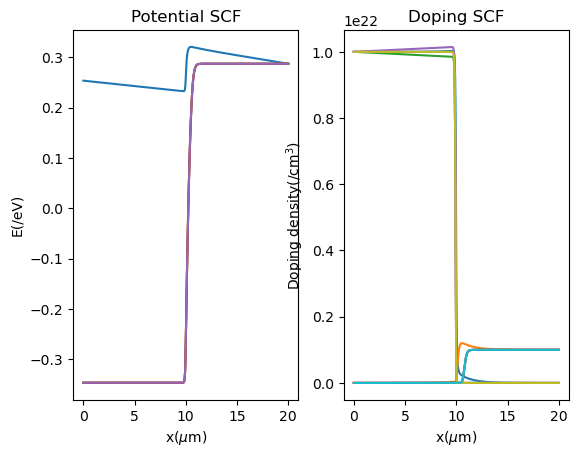

In [3]:
import math
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, interactive
from IPython.display import display, clear_output
import copy

# Constants
Vd              = 0
xi, xf, dx, dt  = 0, 0, 0, 0
Nx, TDMnn       = 0, 0
mu_p_P, mu_n_P, mu_p_N, mu_n_N = 0, 0, 0, 0
Ut              = 0
SL              = 0
Na, Nd          = 0, 0
max_diff        = 0
tau_n, tau_p    = 0, 0
p1, n1          = 0, 0
F_scatt         = 0

# Define constants
TDMX    = 5002
nm      = 1e-9                              # (nm)
nm2     = 1e-18                             # (nm)^2
um      = 1e-6                              # micro meter
hp      = 6.63 * math.pow(10, -34)          # Planck constant
ep0     = 8.85 * math.pow(10, -12)          # Permittivity
kB      = 1.38 * math.pow(10, -23)          # Boltzmann constant
me      = 9.11 * math.pow(10, -31)          # Electron mass
ec      = 1.602e-19                         # Elementary charge


# Initialize arrays
x       = [0] * TDMX
x_plot  = [0] * TDMX
p       = [0] * TDMX
n       = [0] * TDMX
p_plot  = [0] * TDMX
n_plot  = [0] * TDMX
p_eq    = [0] * TDMX
n_eq    = [0] * TDMX
Dop     = [0] * TDMX
Dop_x   = [0] * TDMX
Dop_y   = [0] * TDMX
Dop_plot    = [0] * TDMX
Dop_plot_x  = [0] * TDMX
Dop_plot_y  = [0] * TDMX
Charge  = []
V       = [0] * TDMX
DV      = [0] * TDMX
Vx      = [0] * TDMX
E_field = [0] * TDMX
E_field_plot     = []
E_potential_plot = []
Fp_plot = []
Fn_plot = []
E_band_con = []
E_band_int = []
E_band_val = []
Jt_plot = []
Jp_plot = []
Jn_plot = []
JV      = []
JV_plot = []
depletion = []

mu_p    = [0] * TDMX
mu_n    = [0] * TDMX
Dp      = [0] * TDMX
Dn      = [0] * TDMX
max_diff = []
li_density_p=[]
li_density_n=[]
li_pot=[]
# ni      = 1.5e10

original_xlim = None

def iniBC(V_iter):
    global ni, Na, Nd, Ut, V, E_field, p, n
    V[0] = -Ut * math.log(Na / ni) + Vd     # 왼쪽 끝단의 전위 설정
    V[Nx + 1] = Ut * math.log(Nd / ni)      # 오른쪽 끝단의 전위 설정
    for i in range(Nx + 2):
        if x[i] < 0.5*SL: 
            V[i] = V[0]                     # 왼쪽 절반의 전위 설정
        else:             
            V[i] = V[Nx + 1]                # 오른쪽 절반의 전위 설정
    for i in range(1, Nx + 1): 
        E_field[i] = -(V[i + 1] - V[i - 1]) / (2 * dx)       
    for i in range(Nx + 2):
        p[i] = p_eq[i]                      ## initial hole charge density
        n[i] = n_eq[i]                      ## initial electron charge density
        
def calc_J(V_iter):                         # 전류 밀도 계산 함수
    global Nx, dx, Dp, Dn, Ut, V, JV_plot, Jt_plot, Jp_plot, Jn_plot, p, n, ec

    JV.append(0)
    JV_plot.append(0)

    for i in range(1, Nx + 1):
        Jp_plot[V_iter][i] = -ec * Dp[i+1] * (Ber((V[i]-V[i+1])/Ut) * p[i+1] - Ber((V[i+1]-V[i])/Ut) * p[i]) / (1*dx)   # hole current density
        Jn_plot[V_iter][i] = -ec * Dn[i+1] * (Ber((V[i]-V[i+1])/Ut) * n[i] - Ber((V[i+1]-V[i])/Ut) * n[i+1]) / (1*dx)   # electron current density
        Jt_plot[V_iter][i] = Jp_plot[V_iter][i] + Jn_plot[V_iter][i]                                                    # total current density
        JV[V_iter]        += Jt_plot[V_iter][i]

    JV[V_iter] /= (Nx)                      #총 전류 밀도를 공간 격자의 개수(Nx)로 나누어 평균 전류 밀도를 계산
    JV_plot[V_iter] = JV[V_iter]/10000      #단위 변환
def Poisson():
    ''' 
    포아송 방정식을 풀기 위한 함수
    전하 밀도 분포를 이용하여 전기 포텐셜을 계산
    '''
    global ep, max_diff, Ut, V, p, n, Dop, Dop_x, Dop_y, Nx, dx, ec
    diff = 0
    Tol = pow(10, -7)
    a = [0] * TDMX              # 삼중 대각선 행렬의 하부 대각선
    b = [0] * TDMX              # 삼중 대각선 행렬의 주 대각선
    c = [0] * TDMX              # 삼중 대각선 행렬의 상부 대각선
    r = [0] * TDMX              # 오른쪽 항 벡터
    oldV = [0] * TDMX           # 이전 전위 값을 저장할 배열
    iter = 0                    # 반복 횟수 초기화

    for i in range(1, Nx + 1):  # 초기 전위 값을 oldV에 저장
        oldV[i] = V[i]        

    while True:                 # 삼중 대각선 행렬 요소와 오른쪽 항 벡터를 계산
        for i in range(1, Nx + 1):
            a[i] = 1                            # 하부 대각선 요소
            b[i] = -2 - (ec / ep) * dx * dx / Ut * (p[i] * math.exp((oldV[i] - V[i]) / Ut) + n[i] * math.exp((V[i] - oldV[i]) / Ut))    # 주 대각선 요소
            c[i] = 1                             # 상부 대각선 요소
            r[i] = -(V[i + 1] + V[i - 1] - 2 * V[i]) - (ec / ep) * dx * dx * (p[i] * math.exp((oldV[i] - V[i]) / Ut) - n[i] * math.exp((V[i] - oldV[i]) / Ut) - Dop[i]) # 오른쪽 항 벡터

        TDMSolve(a, b, c, r, DV, Nx)            # 삼중 대각선 행렬 방정식을 풀어 DV(전위변화량)을 업데이트

        diff = 0
        for i in range(1, Nx + 1):
            V[i] = V[i] + DV[i]
            diff += abs(DV[i])
        iter += 1
        if diff <= Tol: break                   # 변화량이 허용 오차 이하이면 루프 종료

    diff = 0
    max_diff = 0
    for i in range(1, Nx + 1):
        diff = abs(oldV[i] - V[i])              # 이전 전위와 새로운 전위 간의 차이 계산
        if diff > max_diff: max_diff = diff     # 최대 변화량 갱신

    for i in range(1, Nx + 1):
        E_field[i] = -(V[i + 1] - V[i - 1]) / (2 * dx)  # 중앙 차분법을 사용하여 각 격자점에서 전기장 E_field를 계산

def Conti():    ## 연속방정식 
    global Dn, Dp, tau_n, tau_p
    a = [0.0] * TDMX
    b = [0.0] * TDMX
    c = [0.0] * TDMX
    r = [0.0] * TDMX
    dn = [0.0] * TDMX
    dp = [0.0] * TDMX

    RR_SRH = 0.0

    diff = 0.0
    Tol  = (Na + Nd) / 2 * 1e-8

    # ---------------------------hole------------------------------------------------
    iter = 0

    while True:
        for i in range(1, Nx + 1):
            RR_SRH = 1 / (tau_n * (p[i] + p1) + tau_p * (n[i] + n1))  ## SRH recombination equation 

            # 전하 밀도에 따른 전도도 계수 계산
            co_0 = Dp[i] / (dx * dx)
            co_1 = Dp[i + 1] / (dx * dx)

            # 버텀-리버슨 함수에 기반한 계수 계산
            co_a = co_0 * Ber((V[i] - V[i - 1]) / Ut)  ## <-- p[i+1] 의 계수 
            co_b = co_0 * Ber((V[i - 1] - V[i]) / Ut) + co_1 * Ber((V[i + 1] - V[i]) / Ut) ## <-- p[i] 의 계수 
            co_c = co_1 * Ber((V[i] - V[i + 1]) / Ut)  ## <-- p[i-1] 의 계수 
            
            # 삼중 대각선 행렬의 계수 설정
            a[i] = co_a
            b[i] = -co_b - RR_SRH * n[i] + pow(RR_SRH, 2) * tau_n * (p[i] * n[i] - ni * ni)

            if F_scatt == 0: b[i] = -co_b  # 산란 조건에 따라 b[i] 조정
            c[i] = co_c
            r[i] = co_a * p[i - 1] - co_b * p[i] + co_c * p[i + 1] - RR_SRH * (p[i] * n[i] - ni * ni)
            r[i] = -r[i]
            if F_scatt == 0: r[i] = 0
            # print(F_scatt)  # 디버깅 용도로 산란 조건을 출력

        if F_scatt == 0:
            r[1] = -a[1] * p[0]; a[1] = 0           # 경계 조건 설정 (왼쪽 끝)
            r[Nx] = -c[Nx] * p[Nx + 1]; c[Nx] = 0   # 경계 조건 설정 (오른쪽 끝)
            TDMSolve(a, b, c, r, p, Nx)             # 삼중 대각선 행렬 방정식을 풀어 p를 업데이트
            break
        else:
            TDMSolve(a, b, c, r, dp, Nx)            # 삼중 대각선 행렬 방정식을 풀어 dp를 업데이트
        '''
        산란 조건에 따라 경계 조건을 설정
        TDMSolve 함수는 삼중 대각선 행렬 방정식을 풀어 p 또는 dp 배열을 업데이트
        산란이 없으면 루프를 종료
        '''
        diff = 0

        for i in range(1, Nx + 1):
            p[i] = p[i] + dp[i]
            diff += abs(dp[i])

        iter += 1

        if diff <= Tol: break

    # --------------------------- electron------------------------------------------------
    iter = 0

    while True:
        for i in range(1, Nx + 1):
            # SRH 재결합 속도 계산
            RR_SRH = 1 / (tau_n * (p[i] + p1) + tau_p * (n[i] + n1))

            # 확산 계수와 격자 간격을 이용해 전달 계수 계산
            co_0 = Dn[i] / (dx * dx)
            co_1 = Dn[i + 1] / (dx * dx)
            co_a = co_0 * Ber((V[i - 1] - V[i]) / Ut)
            co_b = co_1 * Ber((V[i] - V[i + 1]) / Ut) + co_0 * Ber((V[i] - V[i - 1]) / Ut)
            co_c = co_1 * Ber((V[i + 1] - V[i]) / Ut)

            # 삼중 대각선 행렬 요소 설정
            a[i] =  co_a
            b[i] = -co_b - RR_SRH * p[i] + pow(RR_SRH, 2) * tau_p * (p[i] * n[i] - ni * ni)
            if F_scatt == 0: b[i] = -co_b
            c[i] = co_c

             # 오른쪽 벡터 r[i] 설정
            r[i] = co_a * n[i - 1] - co_b * n[i] + co_c * n[i + 1] - RR_SRH * (p[i] * n[i] - ni * ni)
            r[i] = -r[i]
            if F_scatt == 0: r[i] = 0

        if F_scatt == 0:
            # 산란이 없을 때 경계 조건 설정 및 TDMSolve 호출
            r[1] = -a[1] * n[0]        ; a[1] = 0
            r[Nx] = -c[Nx] * n[Nx + 1] ; c[Nx] = 0
            TDMSolve(a, b, c, r, n, Nx)
            break
        else:
            # 산란이 있을 때 TDMSolve 호출
            TDMSolve(a, b, c, r, dn, Nx)

        diff = 0

        # 전자 밀도 업데이트 및 변화량 계산
        for i in range(1, Nx + 1):
            n[i] = n[i] + dn[i]
            diff += abs(dn[i])

        iter += 1

        if diff <= Tol: break  # 수렴 조건 검사


def TDMSolve(a, b, c, r, outputx, TDMnn):   ##삼대각행렬
    beta = [0.0] * TDMX                     # 중간 계산을 위한 배열 초기화                  
    rho = [0.0] * TDMX                      # 중간 계산을 위한 배열 초기화
    beta[1] = b[1]                          # 첫 번째 대각선 요소 설정
    rho[1] = r[1]                           # 첫 번째 오른쪽 항 벡터 요소 설정

    for j in range(2, TDMnn + 1):
        beta[j] = b[j] - a[j] * c[j - 1] / beta[j - 1]  # 새로운 대각선 요소 계산
        rho[j] = r[j] - a[j] * rho[j - 1] / beta[j - 1] # 새로운 오른쪽 항 벡터 요소 계산
    outputx[TDMnn] = rho[TDMnn] / beta[TDMnn]

    for j in range(1, TDMnn):
        outputx[TDMnn - j] = (rho[TDMnn - j] - c[TDMnn - j] * outputx[TDMnn - j + 1]) / beta[TDMnn - j]

def Ber(x):   ## 테일러 급수 근사를 이용한 버만 함수 
    if abs(x) < 1e-7:
        return 1 - x / 2 + x * x / 12 - x * x * x * x / 720  # 충분히 작은 x에 대한 테일러 급수 근사
    else:
        return x / (math.exp(x) - 1)          # 일반적인 경우의 버만 함수

def set_parameters_from_table():
    global ni
    global Na, Nd
    global Nx, x, dx
    global Ut
    global V, E, p, n
    global SL
    global mu_p_P, mu_p_N, mu_n_P, mu_n_N
    global Dp, Dn, tau_n, tau_p, p1, n1
    global F_scatt
    global Vd
    global V_min, V_max, V_step
    global Parameter_input  

    V_min   = float(Parameter_input[0].value)
    V_max   = float(Parameter_input[1].value)
    V_step  = float(Parameter_input[2].value)
    Vd      = float(Parameter_input[3].value)
    ni      = float(Parameter_input[4].value) /um       #* 1e6
    SL      = float(Parameter_input[5].value) *um       #* 1e-6    
    Na      = float(Parameter_input[6].value) /um       #* 1e6
    Nd      = float(Parameter_input[7].value) /um       #* 1e6
    mu_p_P  = float(Parameter_input[8].value) * 1e-4
    mu_p_N  = float(Parameter_input[9].value) * 1e-4
    mu_n_P  = float(Parameter_input[10].value) * 1e-4
    mu_n_N  = float(Parameter_input[11].value) * 1e-4
    tau_n   = float(Parameter_input[12].value) *um      #* 1e-6 
    tau_p   = float(Parameter_input[13].value) *um      #* 1e-6 
    p1      = float(Parameter_input[14].value)
    n1      = float(Parameter_input[15].value)
    F_scatt = float(Parameter_input[16].value)          # SRH --> 1 로 지정

#--------------------------------------------------------------------
def main():
    # Global variable declarations
    global ni, Na, Nd, Nx, x, dx, Ut, V, E, p, n, Dop, Dop_x, Dop_y, SL
    global mu_p_P, mu_p_N, mu_n_P, mu_n_N, Dp, Dn, tau_n, tau_p, p1, n1
    global F_scatt, Vd, ep, ec, JV, JV_plot, Jp_plot, Jn_plot, Vd_arr, VV, depletion
    global E_field_plot, E_potential_plot, max_diff, L_Box, Fig_widget, fig_G, ax_G
    global li_density_p, li_density_n, li_pot

    # Initialize Fig_widget for new output
    with Fig_widget:
        clear_output(wait=True)
    
    # Constants and initializations
    Tol = 1e-7    
    ep = 11.7 * ep0
    TR = 300
    Ut = kB * TR / ec
    Eg = 1.12
    xi = 0.0
    xf = SL
    Nx = 5000
    dx = (xf - xi) / (Nx + 1)
    x = [xi + i * dx for i in range(Nx + 2)]

    for i in range(Nx + 2): 
        x[i] = xi + i * dx
        x_plot[i] = x[i] / um

    for i in range(Nx + 2):
        if x[i] < 0.5 * SL:
            mu_p[i] = mu_p_P    ## Majority carrier: Pp 
            mu_n[i] = mu_n_P    ## Minority carrier: Pn
        else:
            mu_p[i] = mu_p_N    ## Majority carrier: Nn
            mu_n[i] = mu_n_N    ## Minority carrier: Np

    for i in range(Nx + 2):
        Dp[i] = mu_p[i] * Ut    ## Einstein equation 
        Dn[i] = mu_n[i] * Ut    ## Einstein equation 

    for i in range(Nx + 2):
        Dop[i]        = Na if x[i] < 0.5*SL else -Nd        ## Doping concentration: Na - Nd
        Dop_x[i]      = Na if x[i] < 0.5*SL else 0          ## Doping concentration: Na
        Dop_y[i]      = Nd if x[i] > 0.5*SL else 0          ## Doping concentration: Nd
        Dop_plot[i]   = Dop[i]/1e6
        Dop_plot_x[i] = Dop_x[i]/1e6
        Dop_plot_y[i] = Dop_y[i]/1e6

    for i in range(Nx + 2):
        p_eq[i] = 0.5 * (math.sqrt(pow(Dop[i], 2) + 4 * pow(ni, 2)) + Dop[i])   ## 디리클레 경계조건
        n_eq[i] = 0.5 * (math.sqrt(pow(Dop[i], 2) + 4 * pow(ni, 2)) - Dop[i])   ## 디리클레 경계조건   

    V_iter = 0  ## Current에 사용 
    Vd_arr =[]
    ax_G = np.empty((3, 3), dtype=object)

    V_iter =0
    
    for VV in np.arange(V_min, V_max + V_step / 2, V_step):
        Vd_arr.append(VV)
        Vd=VV
        iniBC(V_iter)
        if V_iter == 0:
            li_pot.append(V)
            li_density_p.append(p)
            li_density_n.append(n)
        while True:
            Poisson()
            Conti()
            if V_iter == 0:
                li_pot.append(copy.deepcopy(V))
                li_density_p.append(copy.deepcopy(p))
                li_density_n.append(copy.deepcopy(n))
                
            if max_diff <= Tol: break  
        Charge.append([0] * TDMX)               
        E_band_con.append(V_iter)   ; E_band_con[V_iter]    = [0] * TDMX
        E_band_int.append(V_iter)   ; E_band_int[V_iter]    = [0] * TDMX
        E_band_val.append(V_iter)   ; E_band_val[V_iter]    = [0] * TDMX
        E_field_plot.append(V_iter) ; E_field_plot[V_iter]  = [0] * TDMX    
        E_potential_plot.append(V_iter) ; E_potential_plot[V_iter] = [0] * TDMX
        p_plot.append(V_iter)       ; p_plot[V_iter]       = [0] * TDMX
        n_plot.append(V_iter)       ; n_plot[V_iter]       = [0] * TDMX
        Fp_plot.append(V_iter)      ; Fp_plot[V_iter]      = [0] * TDMX
        Fn_plot.append(V_iter)      ; Fn_plot[V_iter]      = [0] * TDMX
        Jp_plot.append(V_iter)      ; Jp_plot[V_iter]      = [0] * TDMX
        Jn_plot.append(V_iter)      ; Jn_plot[V_iter]      = [0] * TDMX
        Jt_plot.append(V_iter)      ; Jt_plot[V_iter]      = [0] * TDMX

        for i in range(Nx + 2):
            Fp_plot[V_iter][i] = -V[i] - Ut * math.log(p[i] / ni)   ## QFL --> charge density의 변화량에 의해 정의
            Fn_plot[V_iter][i] = -V[i] + Ut * math.log(n[i] / ni)   ## QFL --> charge density의 변화량에 의해 정의
            Charge[V_iter][i] = (p[i] - n[i] - Dop[i]) / 1e6        ## Net charge density 
            E_potential_plot[V_iter][i] = V[i]                      ## electrostatic potential
            p_plot[V_iter][i]       = p[i]/ 1e6                     ## Charge density (P)
            n_plot[V_iter][i]       = n[i]/ 1e6                     ## Charge density (P)
            E_field_plot[V_iter][i] = E_field[i]/1e5                ## E fieldv
            E_band_con[V_iter][i]   = -V[i] + 0.5 * Eg              ## Conduction band (Ec)
            E_band_int[V_iter][i]   = -V[i]                         ## Intrinsic level (E_fi)
            E_band_val[V_iter][i]   = -V[i] - 0.5 * Eg              ## Valence band (Ev)

        calc_J(V_iter)

        dV_dx = [(V[i + 1] - V[i - 1]) / (2 * dx) for i in range(1, Nx + 1)]
        dV_dx_abs = [abs(dV) for dV in dV_dx]
        threshold = max(dV_dx_abs) * 0.1  # Define a threshold for significant gradient change
        depletion_start = next(x[i] for i in range(1, Nx + 1) if dV_dx_abs[i - 1] > threshold)
        depletion_end = next(x[i] for i in reversed(range(1, Nx + 1)) if dV_dx_abs[i - 1] > threshold)
        depletion_length = (depletion_end - depletion_start)/um
        depletion.append(depletion_length)
        V_iter += 1

    plot_scf()
    plot_graphs()


color = ['orange', 'darkcyan', 'r', 'b','gray','gray-','k','m']

def plot_scf():
    global li_density_p, li_density_n, li_pot

    Fig_widget.clear_output(wait=True)
    #fig_G = plt.figure(figsize=(12.0,10.0), dpi=90) 
    set_parameters_from_table()
    #ax_G = np.empty((3, 3), dtype=object)
    #G_i = 0
    fig, axes= plt.subplots(1, 2)
    for i in range(len(li_pot)):
        axes[0].plot(x_plot, li_pot[i])
        axes[0].set_title('Potential SCF')
        axes[0].set_xlabel('x($\mu$m)')
        axes[0].set_ylabel('E(/eV)')

        axes[1].plot(x_plot,li_density_p[i], x_plot, li_density_n[i])
        axes[1].set_title('Doping SCF')
        axes[1].set_xlabel('x($\mu$m)')
        axes[1].set_ylabel('Doping density(/cm$^3$)')



def plot_graphs():
    global fig_G, ax_G, Fig_widget,SL, x_plot, Vd_arr, JV_plot, Dop_plot, Jp_plot, Jn_plot, Jt_plot, Vd, VV, Vd_arr, Depletion
    global p_plot, n_plot, E_field_plot, Charge, E_band_con, E_band_int, E_band_val, Fp_plot, Fn_plot
    
    set_parameters_from_table()

    Vd_arr = np.around(np.arange(V_min, V_max + V_step / 2, V_step), decimals=1)

    Fig_widget.clear_output(wait=True)
    fig_G = plt.figure(figsize=(12.0,10.0), dpi=90) 
    set_parameters_from_table()
    SL = int(SL/um)
    shift_SL = SL/2
    Depletion = []
    
    with Fig_widget:
        Vd_arr_vaal = 0
        for i, Vd_arr_vaal in enumerate(Vd_arr):
            V_iter = 0
            if Vd == Vd_arr_vaal:
                Depletion = depletion[i]
                V_iter = i


                def set_custom_xticks(ax):
                    ticks = ax.get_xticks()
                    new_labels = [f"{tick - shift_SL:.1f}" for tick in ticks]
                    ax.set_xticks(ticks)
                    ax.set_xticklabels(new_labels)
                    ax.set_xlim([-0.5, 20.5]) 

                G_i = 0
                ax_G[0, G_i] = fig_G.add_subplot(3, 3, G_i + 1)
                ax_G[0, G_i].plot(x_plot, Dop_plot_x, color[1],  x_plot, Dop_plot_y, color[0])
                ax_G[0, G_i].set_title('Doping density')
                ax_G[0, G_i].set_xlabel('x($\mu$m)')
                ax_G[0, G_i].set_ylabel('Doping density(/cm$^3$)')
                set_custom_xticks(ax_G[0, G_i]) 

                G_i = 1
                ax_G[0, G_i] = fig_G.add_subplot(3, 3, G_i + 1)
                ax_G[0, G_i].set_title('Carrier density')
                ax_G[0, G_i].set_xlabel('x($\mu$m)')
                ax_G[0, G_i].set_ylabel('Carrier density(/cm$^3$)')
                p_min = min(p_plot[V_iter])
                p_max = max(p_plot[V_iter])
                n_min = min(n_plot[V_iter])
                n_max = max(n_plot[V_iter])
                y_min = min(p_min, n_min) / 1e2
                y_max = max(p_max, n_max) * 1e2
                ax_G[0, G_i].set_ylim(y_min, y_max)  
                if any(p_plot[V_iter]) > 0 or any(n_plot[V_iter]) > 0:
                    ax_G[0, G_i].set_yscale('log', base=10)
                ax_G[0, G_i].plot(x_plot, p_plot[0], color[1], x_plot, n_plot[0], color[0])

                if Vd == 0:
                    ax_G[0, G_i].plot(x_plot, p_plot[0], color[1], x_plot, n_plot[0], color[0])
                else:
                    ax_G[0, G_i].plot(x_plot, p_plot[V_iter], color[3], x_plot, n_plot[V_iter],color[2])
                set_custom_xticks(ax_G[0, G_i]) 

                G_i = 2
                ax_G[0, G_i] = fig_G.add_subplot(3, 3, G_i + 1)
                ax_G[0, G_i].set_title('Net charge density')
                ax_G[0, G_i].set_xlabel('x($\mu$m)')
                ax_G[0, G_i].set_ylabel('Charge density(/cm$^3$)')
                ax_G[0, G_i].plot(x_plot, Charge[0],color[0])
                if Vd == 0:
                    ax_G[0, G_i].plot(x_plot, Charge[0],color[0])
                else      :
                    ax_G[0, G_i].plot(x_plot, Charge[V_iter],color[7])
                set_custom_xticks(ax_G[0, G_i])

                G_i = 0
                ax_G[1, G_i] = fig_G.add_subplot(3, 3, G_i + 4)
                ax_G[1, G_i].set_title('Electric field')
                ax_G[1, G_i].set_xlabel('x($\mu$m)')
                ax_G[1, G_i].set_ylabel('E field(kV/cm)')
                ax_G[1, G_i].plot(x_plot, E_field_plot[0],color[0])
                if Vd == 0:
                    ax_G[1, G_i].plot(x_plot, E_field_plot[0],color[0])
                else      :
                    ax_G[1, G_i].plot(x_plot, E_field_plot[V_iter],color[7])
                set_custom_xticks(ax_G[1, G_i])

                G_i = 1
                ax_G[1, G_i] = fig_G.add_subplot(3, 3, G_i + 4)
                ax_G[1, G_i].set_title('Electrostatic potential')
                ax_G[1, G_i].set_xlabel('x($\mu$m)')
                ax_G[1, G_i].set_ylabel('Potential(V/cm$^2$)')
                min1 = min(E_potential_plot[0])
                max1 = max(E_potential_plot[0])
                shift_V_0 = max(E_potential_plot[0])
                shift_V = max(E_potential_plot[V_iter])
                ax_G[1, G_i].set_ylim(min1-max1-0.1, 0.1)
                ax_G[1, G_i].plot(x_plot, [y - shift_V_0 for y in E_potential_plot[0]], color[0])
                if Vd == 0:
                    ax_G[1, G_i].plot(x_plot, [y - shift_V_0 for y in E_potential_plot[0]], color[0])
                else      :
                    ax_G[1, G_i].plot(x_plot, [y - shift_V for y in E_potential_plot[V_iter]],color[7])
                set_custom_xticks(ax_G[1, G_i])

                G_i = 2
                ax_G[1, G_i] = fig_G.add_subplot(3, 3, G_i + 4)
                ax_G[1, G_i].set_title('Energy bands')
                ax_G[1, G_i].set_xlabel('x($\mu$m)')
                ax_G[1, G_i].set_ylabel('Energy - ($\mu$L-$\mu$R)/2(eV)')
                shift = Vd/2
                # min1 = min(y+shift for y in E_band_con[0])
                # max1 = max(y+shift for y in E_band_val[0])
                ax_G[1, G_i].set_ylim(-1.0, 1.0)  
                if Vd == 0:
                    ax_G[1, G_i].plot(x_plot, [y + shift for y in E_band_con[0]], color[0])
                    ax_G[1, G_i].plot(x_plot, [y + shift for y in E_band_int[0]], 'gray', linestyle='dashed')
                    ax_G[1, G_i].plot(x_plot, [y + shift for y in E_band_val[0]], color[1])
                    ax_G[1, G_i].plot(x_plot, [y + shift for y in Fp_plot[0]],color[4], x_plot, [y + shift for y in Fn_plot[0]],color[4])
                else: 
                    ax_G[1, G_i].plot(x_plot, [y + shift for y in E_band_con[V_iter]], color[2])
                    ax_G[1, G_i].plot(x_plot, [y + shift for y in E_band_int[V_iter]], 'gray', linestyle='dashed')
                    ax_G[1, G_i].plot(x_plot, [y + shift for y in E_band_val[V_iter]], color[3])
                    ax_G[1, G_i].plot(x_plot, [y + shift for y in Fp_plot[V_iter]],color[4], x_plot, [y + shift for y in Fn_plot[V_iter]],color[4])
                set_custom_xticks(ax_G[1, G_i])

                G_i = 0
                ax_G[2, G_i] = fig_G.add_subplot(3,3,G_i+7)
                ax_G[2, G_i].plot(Vd_arr, JV_plot, color[6], marker = 'o')
                ax_G[2, G_i].set_title('J - V curve')
                ax_G[2, G_i].set_xlabel('Bias(V)')
                ax_G[2, G_i].set_ylabel('Current density(A/cm$^2$)')

                G_i = 1
                ax_G[2, G_i] = fig_G.add_subplot(3,3,G_i+7)
                ax_G[2, G_i].set_xlabel('x($\mu$m)')
                ax_G[2, G_i].set_ylabel('Current density(A/cm$^2$)')
                ax_G[2, G_i].set_yscale('log', base=10)
                ax_G[2, G_i].set_title('Current density')
                if Vd == 0:
                    pass
                else      :
                    ax_G[2, G_i].plot(x_plot, Jp_plot[V_iter],color[2], x_plot, Jn_plot[V_iter], color[3],x_plot, Jt_plot[V_iter],color[6])                    
                set_custom_xticks(ax_G[2, G_i])

                plt.tight_layout()
                plt.close(fig_G)
                display(fig_G)
        #---------------------------------------------

    R_components = [Fig_widget]
    R_Box  = VBox(R_components)
    L_Box.layout = make_box_layout()
    R_Box.layout = make_box_layout()
    A_Box  = HBox([L_Box, R_Box])    

    display(A_Box)

def zoom_in(change):
    global ax_G, Fig_widget, fig_G, original_xlim, SL, Depletion, V_iter
    V_iter =0
    if change['new']:
        with Fig_widget:
            clear_output(wait=True)
            if original_xlim is None:
                original_xlim = [ax.get_xlim() for ax in ax_G.flatten() if ax is not None]
            for ax in ax_G.flatten():
                if ax is not None:
                    ax.set_xlim(SL/2-2, SL/2 +2)
                    new_ticks = list(range(int(SL/2 - 2), int(SL/2 + 3)))
                    new_labels = [f"{tick - SL/2:.1f}" for tick in new_ticks]
                    ax.set_xticks(new_ticks)
                    ax.set_xticklabels(new_labels)
            display(fig_G)

def zoom_out(change):
    global ax_G, Fig_widget, fig_G, original_xlim
    if change['new']:
        with Fig_widget:
            clear_output(wait=True)
            if original_xlim is not None:
                for i, ax in enumerate(ax_G.flatten()):
                    if ax is not None:
                        ax.set_xlim(original_xlim[i])
            display(fig_G)

def update_V_plot(V_i):
    global ax_G, E_field_plot, fig_G, Fig_widget, V_slider
    with Fig_widget:
        clear_output(wait=True)
        display(fig_G)

def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='0px 0px 0px 0px',
        width = 'auto'
     )

def New_calculation1():
    set_parameters_from_table()
    main()
  
def New_calculation2():
    set_parameters_from_table()
    plot_graphs()

def on_click(change):
    if change['new']:
        clear_output(wait=True)
        New_calculation2()

def update_parameters(change):
    global Parameter_input, Vd, Na, Nd
    set_parameters_from_table()

    Vd_value = Parameter_input[3].value
    Na_value = Parameter_input[6].value
    Nd_value = Parameter_input[7].value

    Na_options = [1.5e14 * (10**j) for j in range(4)]+[1e14 * (10**j) for j in range(4)]
    Na_options.sort()
    Nd_options = [1.5e14 * (10**j) for j in range(4)]+[1e14 * (10**j) for j in range(4)]
    Nd_options.sort()
    
    Parameter_input[3].value = Vd_value
    Parameter_input[6].value = Na_value
    Parameter_input[7].value = Nd_value


def Set_widgets():
    global L_Box, Parameter_input, Default_values, Parameter_names, Run_button, Fig_widget, Zoom_button, ZoomOut_button
    set_D_parameters()

    Run_button = widgets.ToggleButton(value=False, description='Run', disabled=False, button_style='', tooltip='Run calculation', icon='check')
    Zoom_button = widgets.ToggleButton(value=False, description='Zoom in', disabled=False, button_style='', tooltip='Zoom in', icon='search')
    ZoomOut_button = widgets.ToggleButton(value=False, description='Zoom out', disabled=False, button_style='', tooltip='Zoom out', icon='zoom-out')

    L_components = []
    Parameter_input = []

    for i in range(len(Parameter_names)):
        if Parameter_names[i] == 'V':
            options = np.around(np.arange(Default_values[0], Default_values[1] + Default_values[2] / 2, Default_values[2]), decimals=1)
            value = Default_values[i] if Default_values[i] in options else 0.0
            dropdown = widgets.Dropdown(options=options, value=value, description=Parameter_names[i]+':', disabled=False)
            dropdown.observe(update_parameters, names='value')
            Parameter_input.append(dropdown)
        elif Parameter_names[i] in ['Na', 'Nd']:
            options = [1.5e14 * (10**j) for j in range(4)]+[1e14 * (10**j) for j in range(4)]
            options.sort()
            value = Default_values[i] if Default_values[i] in options else (options[1] if Parameter_names[i] == 'Na' else options[2])
            dropdown = widgets.Dropdown(options=options, value=value, description=Parameter_names[i]+':', disabled=False)
            dropdown.observe(update_parameters, names='value')
            Parameter_input.append(dropdown)
        else:
            Parameter_input.append(widgets.FloatText(value=Default_values[i], placeholder='', description=Parameter_names[i]+':', disabled=False))

    Run_button.observe(on_click, 'value')
    Zoom_button.observe(zoom_in, 'value')
    ZoomOut_button.observe(zoom_out, 'value')

    L_components.append(Run_button)
    L_components.append(Zoom_button)
    L_components.append(ZoomOut_button)
    for input_widget in Parameter_input:
        L_components.append(input_widget)

    L_Box = VBox(L_components)
    Fig_widget = widgets.Output()

def set_D_parameters():
    global Default_values, Parameter_names
    Default_values = [0.0, 0.6, 0.1, 0.0, 1.5e10, 20.0, 1.0e16, 1.0e15, 200, 450, 700, 1300, 0.001, 0.001, 0.0, 0.0, 1]
    Parameter_names = ['V_min', 'V_max', 'V_step', 'V', 'ni', 'SL', 'Na', 'Nd', 'mu_p_P', 'mu_p_N', 'mu_n_N', 'mu_n_N', 'tau_n', 'tau_p', 'p1', 'n1', 'SRH']

#----------------------------------    
set_D_parameters()
Set_widgets()   
New_calculation1()
